In [2]:
# You need to install `graphviz` on your system. For example: `brew install graphviz`
import numpy as np
import matplotlib.pyplot as plt
from graphviz import Digraph
import math
import random
%matplotlib inline

In [3]:
def f(x):
    return 3*(x**2) - 4*x + 5

In [4]:
f(3.0)

20.0

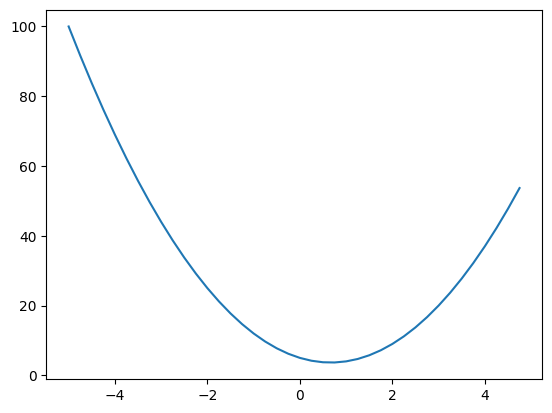

In [14]:
xs = np.arange(-5,5, 0.25)
ys = f(xs)

xs
plt.plot(xs,ys)

In [13]:
hs = np.arange(0.0001,0.0, -0.00001)
x = 2/3
for h in hs:
    val = (f(x+h) - f(x)) / h
    print (f"h={h}, value={val}")

h=0.0001, value=0.0002999999981767587
h=9e-05, value=0.0002699999976682774
h=8e-05, value=0.00023999999765322852
h=7.000000000000001e-05, value=0.0002099999983430832
h=6.000000000000001e-05, value=0.0001800000000902931
h=5.000000000000001e-05, value=0.00014999999464748723
h=4.000000000000001e-05, value=0.000119999987724384
h=3.000000000000001e-05, value=8.99999926436597e-05
h=2.0000000000000012e-05, value=5.9999982759961734e-05
h=1.0000000000000013e-05, value=3.0000002482211093e-05


In [2]:
h = 0.001
a=2.0
b=-3.0
c=10.0

d1 = a*b +c
a += h
d2 = a*b +c

print('d1', d1)
print('d2', d2)
print("slope", (d2-d1) / h)

d1 4.0
d2 3.997
slope -3.0000000000001137


In [2]:
class Module:

    def zero_grad(self):
        for p in self.parameters():
            p.grad = 0

    def parameters(self):
        return []

In [3]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label
    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other) # Wrap the other operand to be `Value`
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other) # Wrap the other operand to be `Value`
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
        out._backward = _backward

        return out

    def __rmul__(self, other): # other * self
        return self * other

    def __truediv__(self, other): # self / other
        return self * other**-1

    def __neg__(self): # -self
        return self * -1

    def __sub__(self, other): # self - other
        return self + (-other)

    def __radd__(self, other): # other + self
        return self + other

    def relu(self):
        out = Value(0 if self.data < 0 else self.data, (self,), 'ReLU')

        def _backward():
            local_grad = 1 if out.data > 0 else 0
            self.grad += (out.data > 0) * out.grad
        out._backward = _backward

        return out
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            local_grad = (1 - t**2)
            self.grad += local_grad * out.grad
        out._backward = _backward
        return out
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            local_gradient = out.data
            self.grad += local_gradient * out.grad
        out._backward = _backward

        return out


    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()


In [4]:
def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  
  # USE DFS to get all the nodes and edges
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect the op node to the node.
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2, instead of n2.
    # For example, we have edge (a,e) in edges, rather than draw edge (a,e) in the graph, we instead draw edge (a,*), '*' is the op node of e.
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

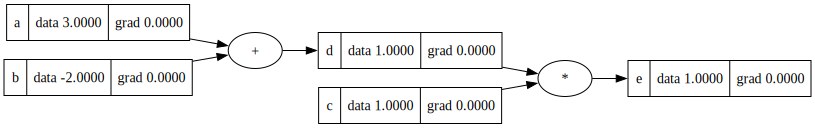

In [6]:
a = Value(3, label='a')
b = Value(-2, label='b')
c = Value(1, label='c')
d = a+b; d.label='d'
e = c * d; e.label='e'
draw_dot(e)

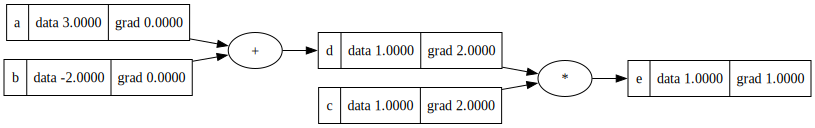

In [8]:
e.grad = 1.0 # The last node should have gradient = 1.0
e._backward()
draw_dot(e)

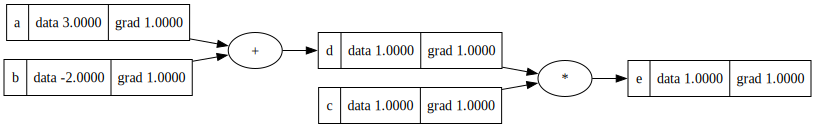

In [36]:
d._backward()
draw_dot(e)

In [18]:
def lol():
  
  h = 0.001
  
  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0, label='c')
  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f; L.label = 'L'
  L1 = L.data
  
  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  b.data += h
  c = Value(10.0, label='c')
  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f; L.label = 'L'
  L2 = L.data
  
  print((L2 - L1)/h)
  
lol()


-3.9999999999995595


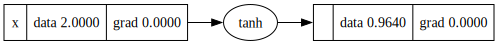

In [25]:
# def tanh(x):
#     out = ((x*2).exp() - 1) / ((x*2).exp() + 1)
#     return out

x =  Value(2.0, label='x')
o = x.tanh()
# o = tanh(x)
draw_dot(o)

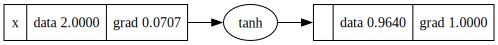

In [24]:
o.grad = 1.0
o.backward()
draw_dot(o)

In [19]:
1 - 0.964**2

0.0707040000000001

In [19]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
o.backward()


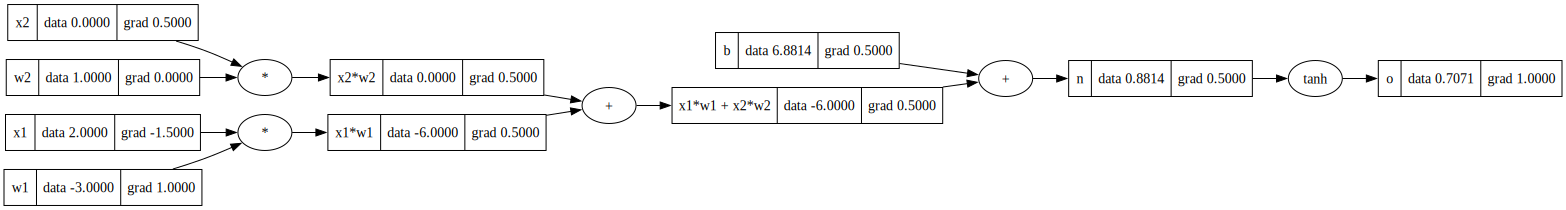

In [20]:
draw_dot(o)

In [37]:
# test grad for tanh.
# d tanh(x) / d x = 1 - (tanh(x))^2, where x = 0.8814, tanh(x) = 0.7071.
# So d tanh(x) / d x = 1 - 0.7071**2 = 0.5000095900000001

1 - 0.7071**2

0.5000095900000001

In [1]:


# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
# ----
before = (n*2)
e = before.exp()
# e = (2*n).exp()
o = (e - 1) / (e + 1)
# ----
o.label = 'o'
o.backward()
draw_dot(o)

NameError: name 'Value' is not defined

In [39]:
import torch


x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())


0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [5]:
class Neuron(Module):
  
  def __init__(self, nin):
      '''
      nin: the dimension of input data point, which is a vector.
      
      Here we initialize the weights and thr bias via a uniform distribution. In practice it's up to you to choose the initialization method, sometimes a normal distribution is better, sometimes we set them to be all zero, there are also more complicated methods such as [Xavier](https://cs230.stanford.edu/section/4/).
      '''
      self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
      self.b = Value(random.uniform(-1,1))
      
  def __call__(self, x):
      '''
      w * x + b, where "*" is dot product
      Then apply tanh as the activation function.
      The output is a scalar.
      '''
      act = sum(w_i * x_i for w_i, x_i in zip(self.w, x)) + self.b
      out = act.tanh()
      return out
  
  def parameters(self):
    return self.w + [self.b]
  
class Layer(Module):
  
  def __init__(self, nin, nout):
      '''
      nin: the dimension of input data point, which is a vector.
      nout: the dimension of the output, which equals to the number of the neurons in the layer since each neuron outputs a scalar as one element of the output vector.
      '''
      self.neurons = [Neuron(nin) for _ in range(nout)]
  
  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs # If the output is a vector with length=1, then we output its scalar version instead.
  
  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP(Module):
  
  def __init__(self, nin, nouts):
    '''
    nin: the dimension of input data point, which is a vector.
    nouts: the list of the `nout` of each layer.
    '''
    
    # sz: the size of the MLP.
    # For example, if input vector has dimension=3, we have 3 layers with dimension=4,4,1 separately, then 
    # total size of the MLP is [3,4,4,1], i.e., we add a first layer with size (3,4).
    sz = [nin] + nouts 
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
  
  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x
  
  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

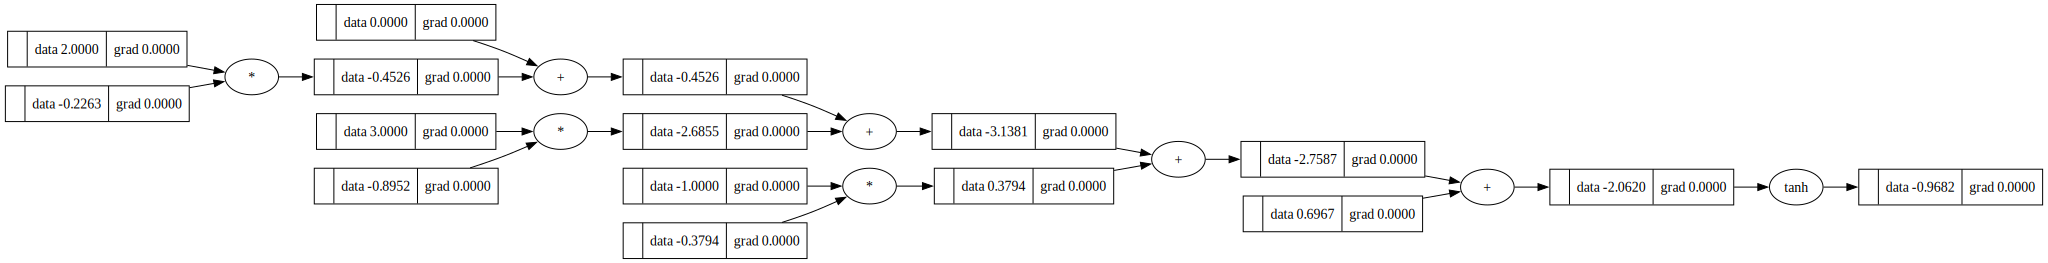

In [30]:
x = [2.0, 3.0, -1.0]
n = Neuron(len(x))
o = n(x)
draw_dot(o)

In [8]:

x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
o = n(x)

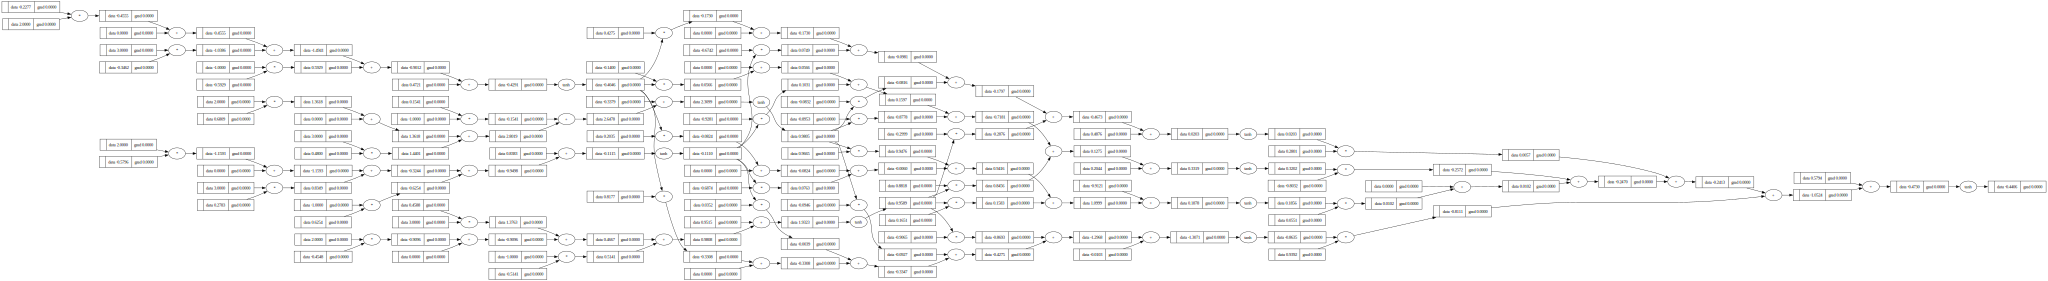

In [9]:
draw_dot(o)

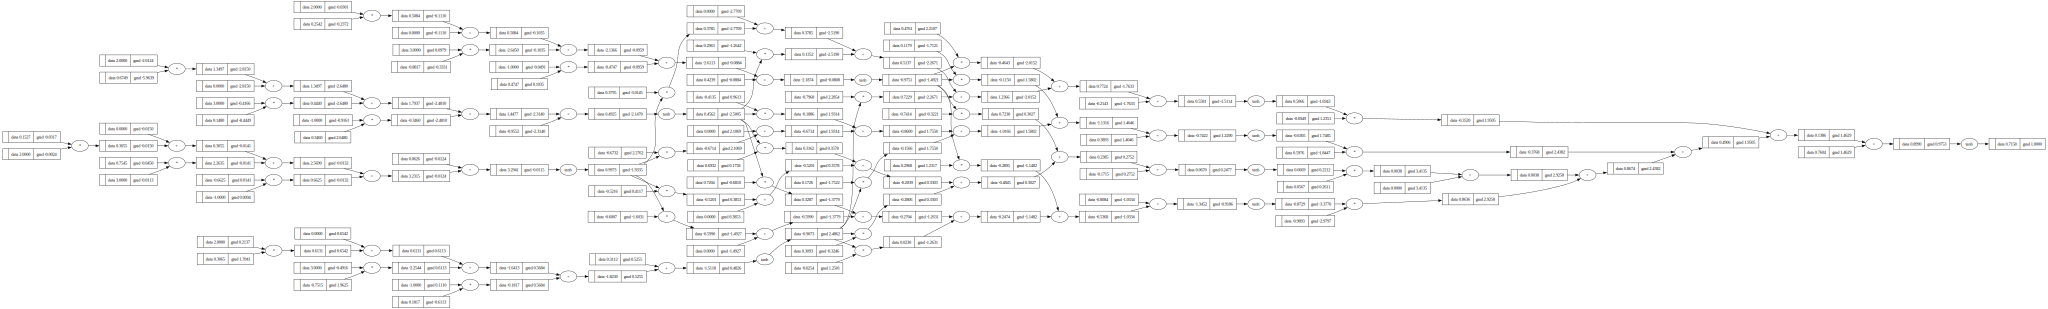

In [35]:
o.backward()
draw_dot(o)

In [43]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [ ]:
def train(episodes=20, learning_rate=-0.1):
    '''
    episodes: the times of the training
    learning_rate: the step size of each gradient descent step
    '''
    for k in range(episodes):
  
        # forward pass
        ypred = [n(x) for x in xs]
        loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred)) # The loss function is simply the MSE loss.
  
        # backward pass
        # n.zero_grad()
        for p in n.parameters():
            p.grad = 0.0
        loss.backward()
  
        # update
        for p in n.parameters():
            p.data += -learning_rate * p.grad
  
        print(k, loss.data)

In [46]:
for k in range(20):
  
    # forward pass
    ypred = [n(x) for x in xs]
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred)) # The loss function is simply the MSE loss.
  
    # backward pass
    # n.zero_grad()
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()
  
    # update
    for p in n.parameters():
        p.data += -0.1 * p.grad
  
    print(k, loss.data)

0 0.010914421869470737
1 0.010607178998341668
2 0.010316046149687896
3 0.010039810454401204
4 0.009777376635805466
5 0.009527753184430911
6 0.00929004042996975
7 0.009063420214452474
8 0.00884714692216669
9 0.008640539663485752
10 0.008442975443617834
11 0.00825388317492148
12 0.008072738414095075
13 0.007899058724211499
14 0.007732399577000131
15 0.007572350723588828
16 0.007418532972589534
17 0.00727059532333559
18 0.007128212409564599
19 0.006991082215143635


In [32]:
ypred

[Value(data=0.9510224635913689),
 Value(data=-0.9529189349175278),
 Value(data=-0.960382486089956),
 Value(data=0.9282044403507367)]